In [1]:
# !pip install graphviz

To produce the decision tree visualization you should install the graphviz package into your system: 
https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

In [2]:
# Run one of these in case you have problems with graphviz

# All users: try this first
# ! conda install graphviz

# If that doesn't work:
# Ubuntu/Debian users only
# ! sudo apt-get update && sudo apt-get install graphviz

# Mac users only (assuming you have homebrew installed)
# ! brew install graphviz

# Windows users, check the stack overflow link. Sorry!

In [3]:
from collections import Counter
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

sns.set()

## Import preprocessed data

In [4]:
df = pd.read_csv(join('..', 'data', 'tugas_preprocessed.csv'))

In [5]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

# Before we proceed

- Consider applying the outlier filtering method discussed last class.
    - We manually filtered the dataset's outliers based on a univariate analysis
- Consider dropping/transforming the variable "rcn". Why?
    - Very little correlation with any other variables
    - Remember the Component planes: the SOM's units were indistinguishable on this variable

In [6]:
# Based on the hyperparameters found in the previous class
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])
Counter(dbscan_labels)

Counter({0: 8715, -1: 102})

In [7]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()

# New df without outliers and 'rcn'
df = df[dbscan_labels!=-1]\
    .drop(columns='rcn')\
    .copy()

# Update metric features list
metric_features = metric_features.drop('rcn')

# Clustering by Perspectives
- Demographic/Behavioral Perspective:
- Product Perspective:

In [8]:
# Split variables into perspectives (example, requires critical thinking and domain knowledge)
demographic_features = [
    'income',
    'frq',
    'per_net_purchase',
    'spent_online'
]

preference_features = [
    'clothes', 
    'kitchen', 
    'small_appliances',
    'toys', 
    'house_keeping', 
]

df_dem = df[demographic_features].copy()
df_prf = df[preference_features].copy()

## Testing on K-means and Hierarchical clustering
Based on (1) our previous tests and (2) the context of this problem, the optimal number of clusters is expected to be between 3 and 7.

In [9]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

### Finding the optimal clusterer on demographic variables

In [10]:
# Obtaining the R² scores for each cluster solution on demographic variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_dem, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_dem, hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.571844,0.095809,0.064693,0.001041,0.544738
3,0.679538,0.582479,0.582650,0.001704,0.655959
4,0.756804,0.671330,0.585952,0.002164,0.711623
5,0.789277,0.700576,0.586480,0.003354,0.758156
6,0.819699,0.748638,0.651671,0.004125,0.782667
7,0.839187,0.777335,0.743790,0.004540,0.805099
8,0.854611,0.796595,0.744352,0.004743,0.823297
9,0.866556,0.828341,0.782224,0.005648,0.838379


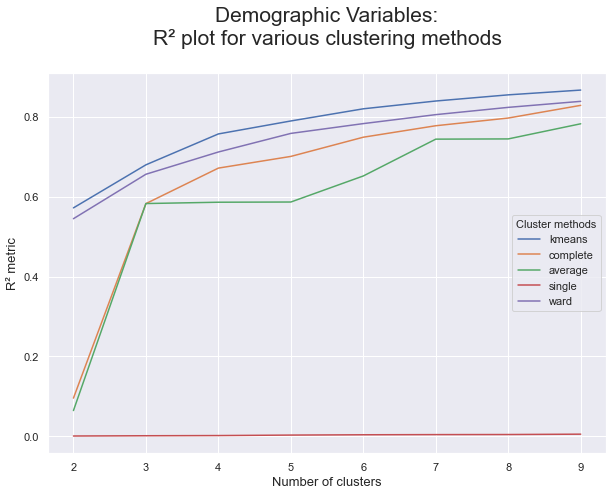

In [11]:
# Visualizing the R² scores for each cluster solution on demographic variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Demographic Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

### Repeat the process for product variables

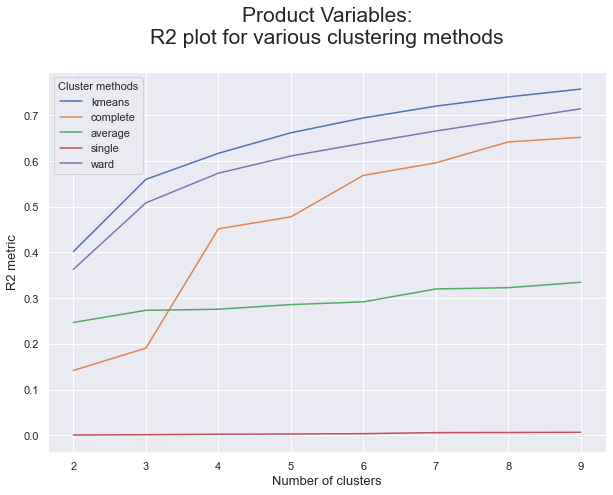

In [12]:
# Obtaining the R² scores for each cluster solution on product variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_prf, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_prf, hierarchical.set_params(linkage=linkage)
    )

# Visualizing the R² scores for each cluster solution on product variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product Variables:\nR2 plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

## Merging the Perspectives
- How can we merge different cluster solutions?

In [13]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans_prod = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
prod_labels = kmeans_prod.fit_predict(df_prf)

kmeans_behav = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=20,
    random_state=42
)
behavior_labels = kmeans_behav.fit_predict(df_dem)

df['product_labels'] = prod_labels
df['behavior_labels'] = behavior_labels

In [14]:
# Count label frequencies (contigency table)
df.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
0,1336,639,207
1,707,247,43
2,388,1233,291
3,1153,1458,1013


### Manual merging: Merge lowest frequency clusters into closest clusters

In [15]:
# Clusters with low frequency to be merged:
to_merge = [(1,2), (1,1), (2,2), (0,2)]

df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()

# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(1, 2): (1, 1), (2, 2): (0, 2)}

In [16]:
df_ = df.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['behavior_labels']==source[0]) & (df_['product_labels']==source[1])
    df_.loc[mask, 'behavior_labels'] = target[0]
    df_.loc[mask, 'product_labels'] = target[1]

# New contigency table
df_.groupby(['product_labels', 'behavior_labels'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
0,1336.0,639.0,498.0
1,707.0,290.0,NaN
2,388.0,1233.0,NaN
3,1153.0,1458.0,1013.0


### Merging using Hierarchical clustering

In [17]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['behavior_labels', 'product_labels'])\
    [metric_features].mean()
df_centroids

income       frq   clothes   kitchen  \
behavior_labels product_labels                                           
0               0               0.140280 -0.080496  1.052776 -0.576134   
                1               0.203474 -0.114649 -0.245723 -0.052970   
                2               0.223129 -0.240270 -0.858325  1.193569   
1               0               0.693508  1.131881  1.099258 -0.601391   
                1               0.935409  1.306561 -0.206583 -0.048124   
                2               0.869229  1.025457 -0.717197  1.073944   
2               0               1.129881  1.207185  0.738408 -0.524402   
                1               1.225127  1.217530 -0.468884 -0.080535   
                2               1.191136  0.953649 -1.098774  1.210396   
3               0              -0.621136 -0.884314  0.951003 -0.603964   
                1              -0.938724 -0.866872 -0.460022 -0.060958   
                2              -1.328229 -0.913881 -1.432161  1.541292   

                                small_appliances      toys  house_keeping  \
behavior_labels product_labels                                              
0               0                      -0.923965 -0.592796      -0.569859   
                1                       0.465742  0.012613       0.017145   
                2                      -0.261014  1.127126       0.866784   
1               0                      -0.958321 -0.621980      -0.603579   
                1                       0.457913 -0.040265      -0.048750   
                2                      -0.300932  0.792654       0.935015   
2               0                      -0.464818 -0.502588      -0.503376   
                1                       0.950322 -0.029960      -0.051247   
                2                       0.246073  1.084451       0.773731   
3               0                      -0.695984 -0.606959      -0.601078   
                1                       0.912056 -0.049288      -0.013862   
                2                       0.021500  1.500632       1.465216   

                                per_net_purchase  spent_online  
behavior_labels product_labels                                  
0               0                       0.093666      0.164015  
                1                      -0.250912      0.051536  
                2                      -0.359403     -0.077162  
1               0                       0.205066      2.073131  
                1                      -0.101336      2.043056  
                2                      -0.187964      1.634177  
2               0                      -1.291168      0.466297  
                1                      -1.465394      0.288564  
                2                      -1.425837      0.189875  
3               0                       0.654463     -0.763638  
                1                       0.830015     -0.789210  
                2                       0.771821     -0.857517

In [18]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

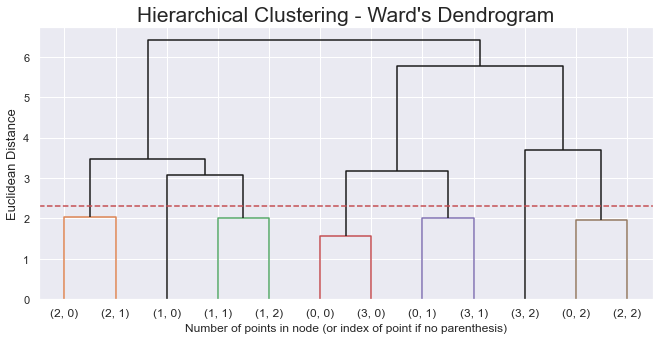

In [19]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 2.3
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [20]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=7
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

income       frq   clothes   kitchen  \
behavior_labels product_labels                                           
0               0               0.140280 -0.080496  1.052776 -0.576134   
                1               0.203474 -0.114649 -0.245723 -0.052970   
                2               0.223129 -0.240270 -0.858325  1.193569   
1               0               0.693508  1.131881  1.099258 -0.601391   
                1               0.935409  1.306561 -0.206583 -0.048124   
                2               0.869229  1.025457 -0.717197  1.073944   
2               0               1.129881  1.207185  0.738408 -0.524402   
                1               1.225127  1.217530 -0.468884 -0.080535   
                2               1.191136  0.953649 -1.098774  1.210396   
3               0              -0.621136 -0.884314  0.951003 -0.603964   
                1              -0.938724 -0.866872 -0.460022 -0.060958   
                2              -1.328229 -0.913881 -1.432161  1.541292   

                                small_appliances      toys  house_keeping  \
behavior_labels product_labels                                              
0               0                      -0.923965 -0.592796      -0.569859   
                1                       0.465742  0.012613       0.017145   
                2                      -0.261014  1.127126       0.866784   
1               0                      -0.958321 -0.621980      -0.603579   
                1                       0.457913 -0.040265      -0.048750   
                2                      -0.300932  0.792654       0.935015   
2               0                      -0.464818 -0.502588      -0.503376   
                1                       0.950322 -0.029960      -0.051247   
                2                       0.246073  1.084451       0.773731   
3               0                      -0.695984 -0.606959      -0.601078   
                1                       0.912056 -0.049288      -0.013862   
                2                       0.021500  1.500632       1.465216   

                                per_net_purchase  spent_online  hclust_labels  
behavior_labels product_labels                                                 
0               0                       0.093666      0.164015              5  
                1                      -0.250912      0.051536              2  
                2                      -0.359403     -0.077162              4  
1               0                       0.205066      2.073131              6  
                1                      -0.101336      2.043056              1  
                2                      -0.187964      1.634177              1  
2               0                      -1.291168      0.466297              0  
                1                      -1.465394      0.288564              0  
                2                      -1.425837      0.189875              4  
3               0                       0.654463     -0.763638              5  
                1                       0.830015     -0.789210              2  
                2                       0.771821     -0.857517              3

In [21]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['behavior_labels'], row['product_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

,income,frq,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
merged_labels,,,,,,,,,
0,1.202329,1.215054,-0.179908,-0.186779,0.611597,-0.143087,-0.159468,-1.423692,0.331106
1,0.925596,1.264880,-0.282295,0.118252,0.345395,0.083237,0.097118,-0.114181,1.982429
2,-0.590673,-0.637654,-0.394721,-0.058524,0.776054,-0.030426,-0.004413,0.500634,-0.533017
3,-1.328229,-0.913881,-1.432161,1.541292,0.021500,1.500632,1.465216,0.771821,-0.857517
4,0.788771,0.457381,-0.998829,1.203402,0.035296,1.102190,0.812410,-0.982560,0.078877
5,-0.212437,-0.452855,1.005631,-0.589026,-0.818356,-0.599357,-0.584321,0.353449,-0.265709
6,0.693508,1.131881,1.099258,-0.601391,-0.958321,-0.621980,-0.603579,0.205066,2.073131


In [22]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['behavior_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['product_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('behavior_labels', 'product_labels', 0)

product_labels,0,1,2
behavior_labels,,,
1,707.0,NaN,290.0
2,NaN,1621.0,498.0
3,2489.0,2097.0,1013.0


In [23]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

## Cluster Analysis

In [24]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

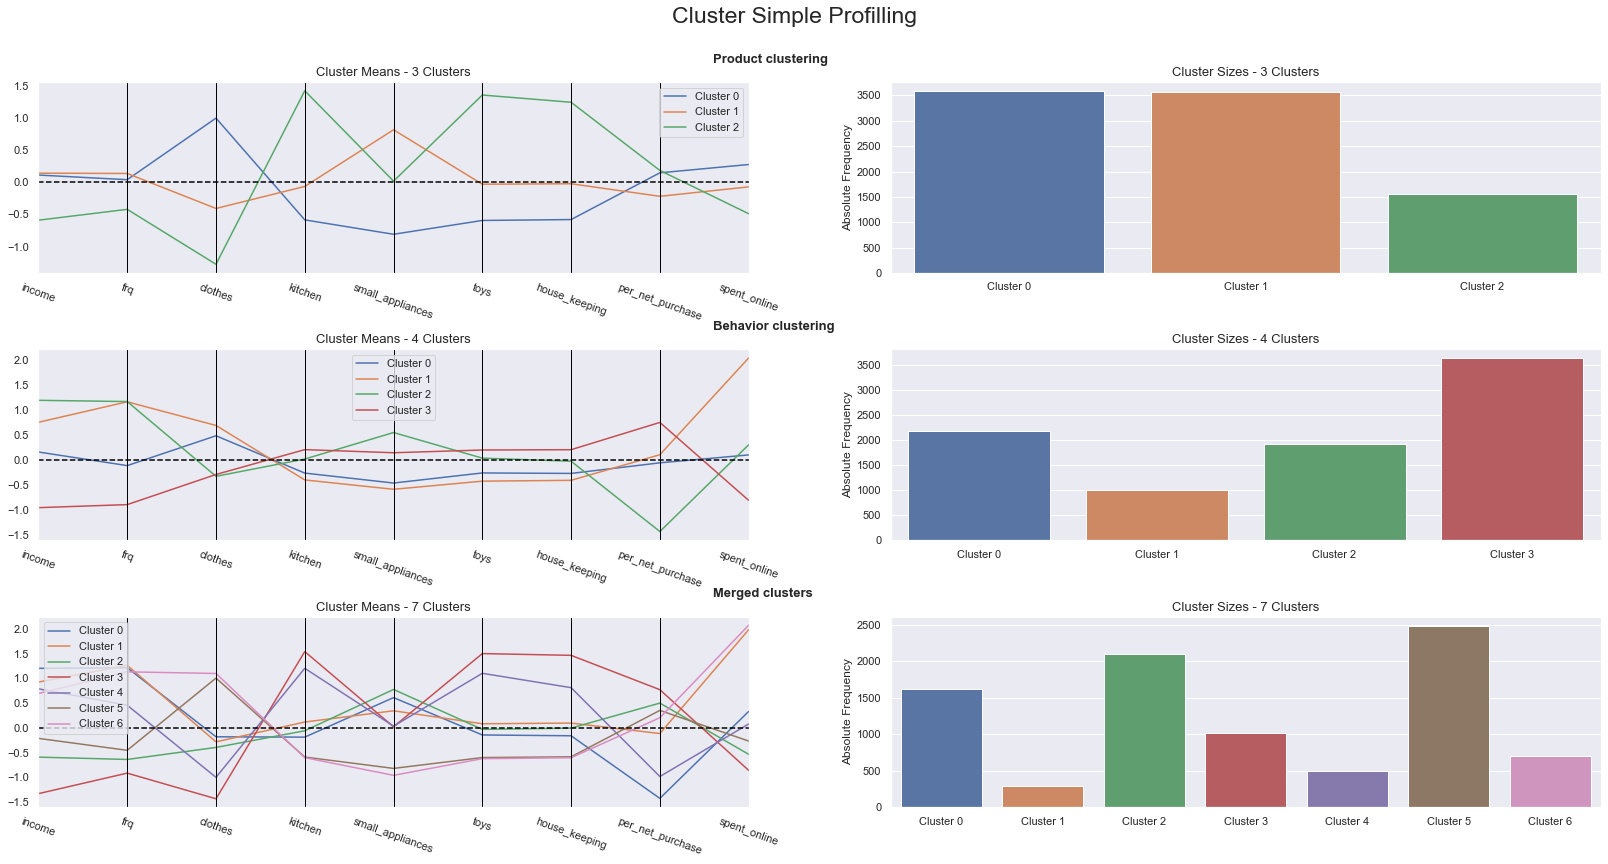

In [25]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df[metric_features.to_list() + ['product_labels', 'behavior_labels', 'merged_labels']], 
    label_columns = ['product_labels', 'behavior_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Product clustering", "Behavior clustering", "Merged clusters"]
)

## Cluster visualization using t-SNE

In [26]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[metric_features])

/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/dm/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


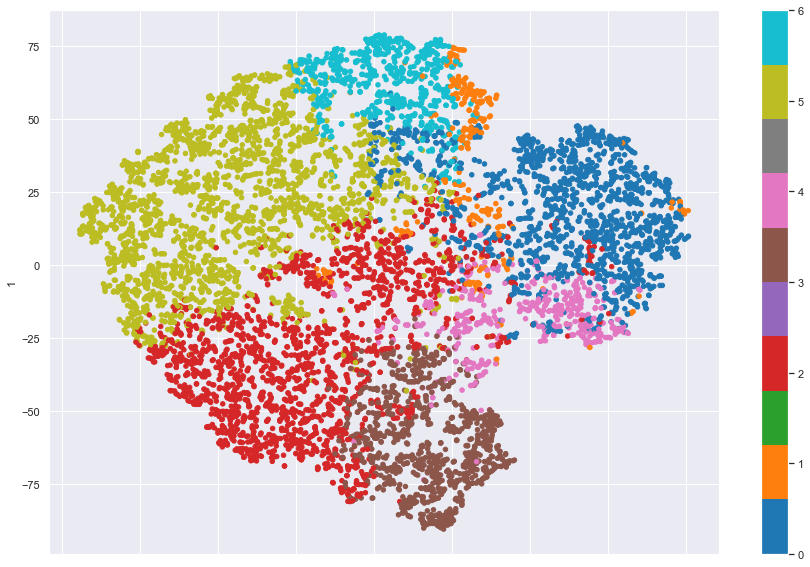

In [27]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

## Assess feature importance and reclassify outliers

### Using the R²
What proportion of each variables total SS is explained between clusters?

In [28]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [29]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features.to_list() + ['merged_labels']], 'merged_labels').drop('merged_labels')

income              0.677635
frq                 0.700979
clothes             0.736866
kitchen             0.516455
small_appliances    0.483580
toys                0.487691
house_keeping       0.468263
per_net_purchase    0.602991
spent_online        0.683896
dtype: float64

### Using a Decision Tree
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [30]:
# Preparing the data
X = df.drop(columns=['product_labels','behavior_labels','merged_labels'])
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 81.93% of the customers correctly


In [31]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns)

income                           0.000000
frq                              0.093061
clothes                          0.309658
kitchen                          0.000000
small_appliances                 0.000000
toys                             0.000000
house_keeping                    0.000000
per_net_purchase                 0.206886
spent_online                     0.193120
x_education_2nd Cycle            0.000000
x_education_Graduation           0.000000
x_education_Master               0.000000
x_education_PhD                  0.000000
x_status_Married                 0.000000
x_status_Single                  0.000000
x_status_Together                0.000000
x_status_Widow                   0.000000
x_gender_M                       0.000000
x_dependents_1.0                 0.000000
x_description_Kind of OK         0.000000
x_description_Meh...             0.000000
x_description_OK nice!           0.000000
x_description_Take my money!!    0.000000
PC0                              0

In [32]:
# Predicting the cluster labels of the outliers
df_out['merged_labels'] = dt.predict(df_out.drop(columns=['rcn']))
df_out.head()

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,...,x_gender_M,x_dependents_1.0,x_description_Kind of OK,x_description_Meh...,x_description_OK nice!,x_description_Take my money!!,PC0,PC1,PC2,merged_labels
15,1.550018,2.199138,0.657173,-1.400205,-0.790228,0.502272,1.075978,3.214455,-1.041124,1.723881,...,1.0,0.0,0.0,0.0,1.0,0.0,0.626497,3.841512,0.781766,0
18,0.705467,-0.640275,-0.273146,-1.704776,-0.379855,-1.165068,3.976684,3.877621,-1.473995,-0.707594,...,1.0,0.0,0.0,1.0,0.0,0.0,-2.708509,2.873128,2.400336,4
77,-0.409958,0.733635,1.255236,-1.226165,-0.653437,1.852024,2.381296,-0.897173,1.339671,2.022158,...,1.0,1.0,0.0,0.0,1.0,0.0,-0.498720,1.294986,-0.888224,2
154,-1.363078,-1.189839,1.554267,-1.791796,1.261634,-1.403260,1.656119,5.071320,-0.067162,-0.985227,...,1.0,1.0,0.0,0.0,1.0,0.0,-4.458206,1.290910,2.286064,3
186,1.063291,-0.457087,1.521041,-1.313185,0.988052,-0.926877,1.221014,3.479722,0.095165,-0.175941,...,0.0,1.0,1.0,0.0,0.0,0.0,-2.072128,1.850197,1.597918,2


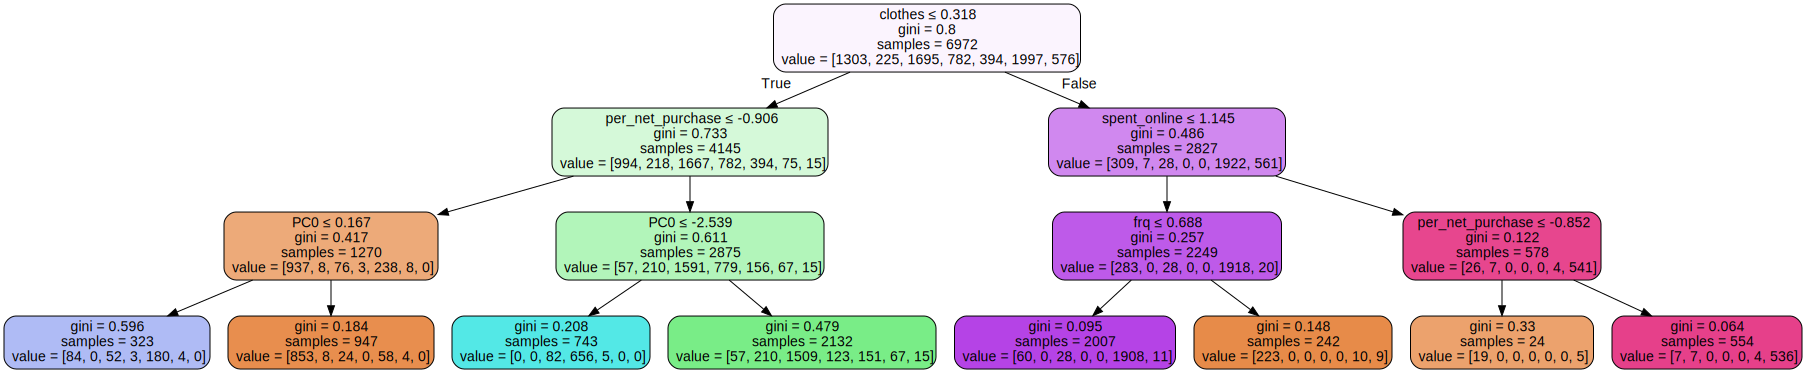

In [33]:
# Visualizing the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)